In [27]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import itertools

import seaborn as sns

### Data

In [9]:
df = pd.read_csv('data/tetragonal.csv')

In [11]:
df = df[df.Zr > 0]

In [12]:
dfrt = df[np.abs(df['T'] - 25) < 10]

In [17]:
inputs = ['T']
features = ['en_p', 'ea', 'valence', 'pettifor', 'rad_ionic', 'rad_slater', 'rad_clementi']
# outputs = ['a', 'c']
outputs = ['a']

### ML

In [38]:
from sklearn.linear_model import LinearRegression, BayesianRidge, Ridge
from sklearn.isotonic import IsotonicRegression
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge as KRR
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error

In [60]:
regressors = {
    'linear': LinearRegression(),
    'ridge': Ridge(),
    'bayesian': BayesianRidge(compute_score=True),
    'gradboost': GradientBoostingRegressor(**{
        'n_estimators': 500,
        'max_depth': 4,
        'min_samples_split': 1.0,
        'learning_rate': 0.01,
        'loss': 'ls'
    }),
    'gaussian': GaussianProcessRegressor(),
    'svr_rbf': SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1),
    'svr_lin': SVR(kernel='linear'),
    'krr_poly': SVR(kernel='poly'),
    'krr_lin': KRR(kernel='linear'),
}

In [61]:
X = df[inputs + features].values
y = df[outputs].values.reshape(-1)

In [62]:
Xr, Xt, yr, yt = train_test_split(X, y, test_size=0.3)

In [63]:
for name, reg in regressors.items():
    print(name)
    reg.fit(Xr, yr)

linear
ridge
bayesian
gradboost
gaussian
svr_rbf
svr_lin
krr_poly
krr_lin


/miniconda3/envs/dskoda/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


/miniconda3/envs/dskoda/lib/python3.7/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/miniconda3/envs/dskoda/lib/python3.7/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/miniconda3/envs/dskoda/lib/python3.7/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


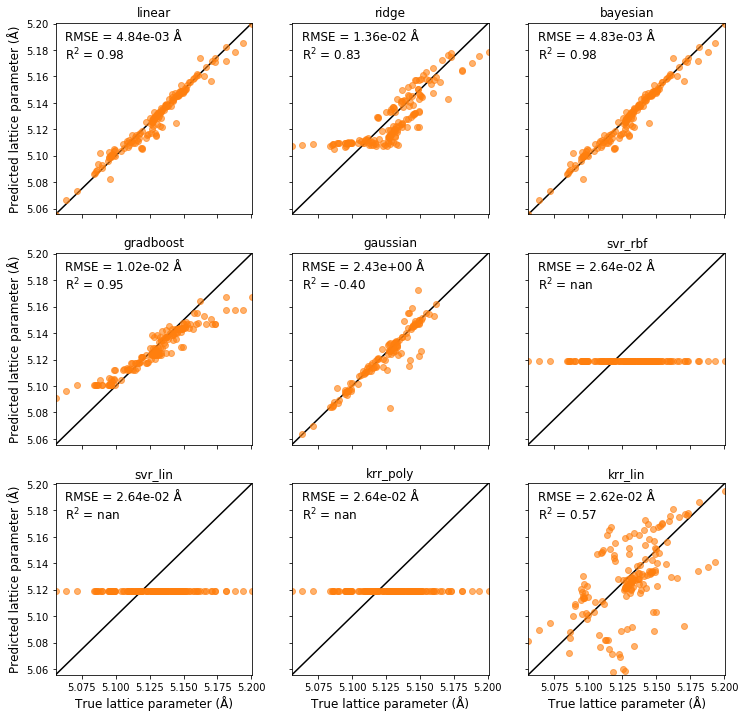

In [72]:
fig, ax_fig = plt.subplots(3, 3, figsize=(12, 12), sharex=True, sharey=True)

for idx, (model, reg) in enumerate(regressors.items()):
    ax = ax_fig[idx // 3, idx % 3]
    
    y_pred = reg.predict(Xt)
    ax.scatter(yt, y_pred, alpha=0.6, c='#ff7f0e')

    rmse = np.sqrt(mean_squared_error(yt, y_pred))
    rsq, _ = stats.pearsonr(yt, y_pred)

    lim_min = min(np.min(yt), np.min(y_plot))
    lim_max = max(np.max(yt), np.max(y_plot))
    lims = (lim_min, lim_max)

    ax.plot(lims, lims, 'k', zorder=-1)

    ax.annotate(
        'RMSE = %.2e Å\nR$^2$ = %.2f' % (rmse, rsq),
        (0.05, 0.96),
        xycoords='axes fraction',
        va='top',
        fontsize=12
    )

    if idx // 3 == 2:
        ax.set_xlabel('True lattice parameter (Å)', fontsize=12)

    if idx % 3 == 0:
        ax.set_ylabel('Predicted lattice parameter (Å)', fontsize=12)

    ax.set_title(model)

    ax.set_xlim(lims)
    ax.set_ylim(lims)
plt.show()

#### All in one figure

In [ ]:
fig, ax_fig = plt.subplots(1, 2, figsize=(13, 6))

for model, reg in regressors.items():
    
    
    for ax, x_plot, y_plot, color, title in zip(ax_fig, [Xr, Xt], [yr, yt], ['#1f77b4', '#ff7f0e'], ['train', 'test']):
        y_pred = reg.predict(x_plot)
        ax.scatter(y_plot, y_pred, alpha=0.6, c=color)

        rmse = np.sqrt(mean_squared_error(y_plot, y_pred))
        rsq, _ = stats.pearsonr(y_plot, y_pred)

        lim_min = min(np.min(y_pred), np.min(y_plot))
        lim_max = max(np.max(y_pred), np.max(y_plot))
        lims = (lim_min, lim_max)
        
        ax.plot(lims, lims, 'k', zorder=-1)
        ax.annotate(
            'RMSE = %.2e Å\nR$^2$ = %.2f' % (rmse, rsq),
            (0.05, 0.96),
            xycoords='axes fraction',
            va='top',
            fontsize=12
        )

        ax.set_xlabel('True lattice parameter (Å)', fontsize=12)
        ax.set_ylabel('Predicted lattice parameter (Å)', fontsize=12)
        ax.set_title(title)

        ax.set_xlim(lims)
        ax.set_ylim(lims)

    fig.suptitle(model)
    plt.show()

### using the bayesian linear model

In [59]:
reg = regressors['bayesian']
for feat, w in zip(inputs + features, reg.coef_):
    print(feat, w)

T 4.9606434751643484e-05
en_p -0.24848949599416814
ea 0.034301665770127165
valence 0.04641403352805784
pettifor 0.1720163117620923
rad_ionic 0.4015653630847904
rad_slater 0.753702053270171
rad_clementi 0.027122518383953853
